In [2]:
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.primitives import StatevectorEstimator as Estimator, StatevectorSampler as Sampler

#Pyscf import
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, TaperedQubitMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator
from qiskit.circuit.library import TwoLocal
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
# General imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

# Import necessary libraries
from openfermion.ops import FermionOperator
from openfermion.transforms import jordan_wigner
from openfermionpyscf import generate_molecular_hamiltonian
from openfermion.linalg import get_sparse_operator
import py3Dmol  # For molecule visualization
from qiskit_algorithms.optimizers import SLSQP, L_BFGS_B
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms.minimum_eigensolvers import AdaptVQE, VQE

# Notebook setup
from IPython.display import display, Markdown

Step 1: Define the H₂ molecule geometry and basis set
Defined geometry: [('H', (0, 0, 0)), ('F', (0, 0, 0.74))]
Using basis: sto-3g
Processing step  0

/tmp/ipykernel_1717618/4030348955.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Distance: 1.30 Å | VQE Energy: -98.55816317 | HF Energy: -98.48863095
 1Distance: 1.35 Å | VQE Energy: -98.54796357 | HF Energy: -98.47043071
 2Distance: 1.40 Å | VQE Energy: -98.53798603 | HF Energy: -98.45192658
 3Distance: 1.45 Å | VQE Energy: -98.52840435 | HF Energy: -98.43331250
 4Distance: 1.50 Å | VQE Energy: -98.51934891 | HF Energy: -98.41475042
 5Distance: 1.55 Å | VQE Energy: -98.51091534 | HF Energy: -98.39638077
 6Distance: 1.60 Å | VQE Energy: -98.50316897 | HF Energy: -98.37832752
 7Distance: 1.65 Å | VQE Energy: -98.49614734 | HF Energy: -98.36069978
 8Distance: 1.70 Å | VQE Energy: -98.48986226 | HF Energy: -98.34359157
 9Distance: 1.75 Å | VQE Energy: -98.48430260 | HF Energy: -98.32708088
10Distance: 1.80 Å | VQE Energy: -98.47943068 | HF Energy: -98.31122910
11Distance: 1.85 Å | VQE Energy: -98.47521824 | HF Energy: -98.29608101
12Distance: 1.90 Å | VQE Energy: -98.47160043 | HF Energy: -98.28166558
13Distance: 1.95 Å | VQE Energy: -98.46851700 | HF Energy: -98.267

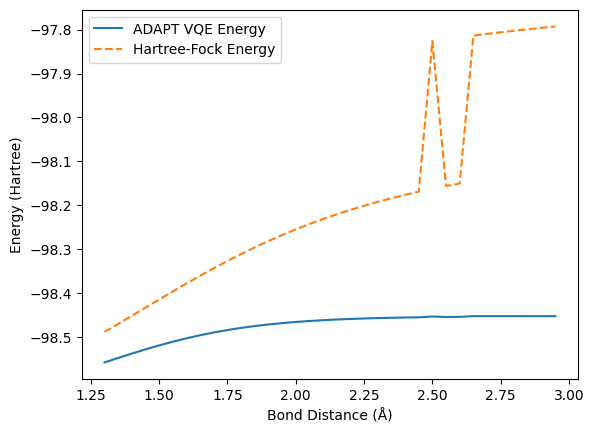

In [3]:
# Display step function
def display_step(message):
    print(message)

display_step("Step 1: Define the H₂ molecule geometry and basis set")
geometry = [('H', (0, 0, 0)), ('F', (0, 0, 0.74))]  # Bond distance ~0.74 Å
basis = 'sto-3g'  # Minimal basis set
multiplicity = 3  # Singlet state (closed shell)
charge = 0  # Neutral H₂ molecule

display_step(f"Defined geometry: {geometry}\nUsing basis: {basis}")

# Define distances for the geometry
# For H2, we will vary the distance between hydrogen atoms to see the energy profile
distances = np.arange(1.3, 3.0, 0.05)  

energies = []
hf_energies = []
estimator = Estimator()


print(f'Processing step __', end='')
for i, d in enumerate(distances):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    try:
        # Update geometry with current distance
        geometry = [('H', (0, 0, 0)), ('F', (0, 0, d))]
        driver = PySCFDriver(atom='; '.join([f'{atom[0]} {atom[1][0]} {atom[1][1]} {atom[1][2]}' for atom in geometry]), basis=basis, charge=charge, spin=multiplicity - 1)
        molecule = driver.run()

        # Freeze core orbitals if applicable
        transformer = FreezeCoreTransformer()
        molecule = transformer.transform(molecule)

        # Generate the Hamiltonian
        hamiltonian = molecule.hamiltonian.second_q_op()

        # Use ParityMapper and get tapered mapper
        mapper = JordanWignerMapper()
        #tapered_mapper = molecule.get_tapered_mapper(mapper)
        tapered_mapper = TaperedQubitMapper(mapper)


        # Set up the ansatz and VQE
        optimizer = L_BFGS_B(maxiter=10000, ftol=1e-9)
        ansatz = UCCSD(
            molecule.num_spatial_orbitals,
            molecule.num_particles,
            tapered_mapper,
            initial_state=HartreeFock(
                molecule.num_spatial_orbitals,
                molecule.num_particles,
                tapered_mapper,
            ),
        )
        vqe = VQE(estimator, ansatz, optimizer)
        adapt_vqe = AdaptVQE(vqe)
        adapt_vqe.initial_point = [0] * ansatz.num_parameters
        algo = GroundStateEigensolver(tapered_mapper, adapt_vqe)
        result = algo.solve(molecule)

        # Debugging outputs
        print(f"Distance: {d:.2f} Å | VQE Energy: {result.total_energies[0]:.8f} | HF Energy: {result.hartree_fock_energy:.8f}")

        # Store energies
        energies.append(result.total_energies[0])
        hf_energies.append(result.hartree_fock_energy)

    except Exception as e:
        print(f"Error at distance {d:.2f} Å: {e}")

print(' --- complete')

# Check if energies list is empty
if not energies or not hf_energies:
    print("Error: No energies were calculated. Please check the loop and debug.")
    exit()

# Find the lowest VQE, Hartree-Fock, and FCI energies
lowest_vqe_energy = min(energies)
lowest_hf_energy = min(hf_energies)

# Find the corresponding distances
lowest_vqe_distance = distances[energies.index(lowest_vqe_energy)]
lowest_hf_distance = distances[hf_energies.index(lowest_hf_energy)]

# Print the lowest energies and corresponding bond distances
print(f"Lowest VQE Energy: {lowest_vqe_energy:.8f} Hartree at bond distance {lowest_vqe_distance:.2f} Å")
print(f"Lowest Hartree-Fock Energy: {lowest_hf_energy:.8f} Hartree at bond distance {lowest_hf_distance:.2f} Å")

# Plotting the energy profile
fig, ax = plt.subplots()
ax.plot(distances, energies, label="ADAPT VQE Energy")
ax.plot(distances, hf_energies, label="Hartree-Fock Energy", linestyle='--')
ax.set_xlabel("Bond Distance (Å)")
ax.set_ylabel("Energy (Hartree)")
ax.legend()
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import Estimator
from qiskit_algorithms.minimum_eigensolvers import VQE
from pyscf import gto, scf, fci

# Display step function
def display_step(message):
    print(message)

display_step("Step 1: Define the LiH molecule geometry and basis set")
basis = 'sto-3g'  # Minimal basis set
multiplicity = 1  # Singlet state (closed shell)
charge = 0  # Neutral molecule

# Define distances for the geometry
distances = np.arange(0.3, 3.0, 0.05)

energies_vqe = []
hf_energies = []
fci_energies = []
estimator = Estimator()

# Define active space
active_electrons = 2  # Number of active electrons
active_orbitals = 4   # Number of active orbitals

# Determine alpha and beta electrons
num_alpha_electrons = active_electrons // 2
num_beta_electrons = active_electrons - num_alpha_electrons

# File to save results
output_file = "converged_results_with_fci.txt"

print(f'Processing step __', end='')
for i, d in enumerate(distances):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    try:
        # Update geometry with current distance
        geometry = [('Li', (0, 0, 0)), ('H', (0, 0, d))]
        
        # Set up PySCF for FCI calculations
        mol = gto.M(atom=geometry, basis=basis, charge=charge, spin=multiplicity - 1, unit="angstrom")
        mf = scf.RHF(mol).run()
        fci_solver = fci.FCI(mol, mf.mo_coeff)
        e_fci, _ = fci_solver.kernel()
        fci_energies.append(e_fci)

        # HF energy
        hf_energies.append(mf.e_tot)

        # VQE Calculations with Active Space
        driver = PySCFDriver(
            atom='; '.join([f'{atom[0]} {atom[1][0]} {atom[1][1]} {atom[1][2]}' for atom in geometry]),
            basis=basis,
            charge=charge,
            spin=multiplicity - 1
        )
        problem = driver.run()

        # Apply the freeze core transformer
        transformer = FreezeCoreTransformer()
        problem = transformer.transform(problem)

        # Generate the Hamiltonian with active space
        hamiltonian = problem.hamiltonian.second_q_op()

        # Restrict the active space
        problem.num_particles = (num_alpha_electrons, num_beta_electrons)
        problem.num_spatial_orbitals = active_orbitals

        # Use Jordan-Wigner mapping
        mapper = JordanWignerMapper()
        qubit_converter = QubitConverter(mapper)

        # Convert the Hamiltonian to qubits
        qubit_operator = qubit_converter.convert(hamiltonian, num_particles=problem.num_particles, num_spatial_orbitals=active_orbitals)

        # Set up the ansatz and VQE
        optimizer = L_BFGS_B(maxiter=10000, ftol=1e-9)
        initial_state = HartreeFock(
            num_spatial_orbitals=active_orbitals,
            num_particles=problem.num_particles,
            qubit_mapper=mapper,
        )
        ansatz = UCCSD(
            num_spatial_orbitals=active_orbitals,
            num_particles=problem.num_particles,
            qubit_mapper=mapper,
            initial_state=initial_state,
        )

        # Verify number of qubits in ansatz and operator
        assert ansatz.num_qubits == qubit_operator.num_qubits, "Mismatch between ansatz and Hamiltonian qubits!"

        vqe = VQE(estimator, ansatz, optimizer)
        algo = GroundStateEigensolver(qubit_converter, vqe)
        result = algo.solve(problem)

        # Debugging outputs
        print(f"Distance: {d:.2f} Å | VQE Energy: {result.total_energies[0]:.8f} | HF Energy: {mf.e_tot:.8f} | FCI Energy: {e_fci:.8f}")

        # Store VQE energy
        energies_vqe.append(result.total_energies[0])

    except Exception as e:
        print(f"Error at distance {d:.2f} Å: {e}")

print(' --- complete')

# Check if energies list is empty
if not energies_vqe or not hf_energies or not fci_energies:
    print("Error: No energies were calculated. Please check the loop and debug.")
    exit()

# Find the lowest energies
lowest_vqe_energy = min(energies_vqe)
lowest_hf_energy = min(hf_energies)
lowest_fci_energy = min(fci_energies)

# Find the corresponding distances
lowest_vqe_distance = distances[energies_vqe.index(lowest_vqe_energy)]
lowest_hf_distance = distances[hf_energies.index(lowest_hf_energy)]
lowest_fci_distance = distances[fci_energies.index(lowest_fci_energy)]

# Save results to a file
with open(output_file, "w") as file:
    file.write("Bond Distance (Å)    VQE Energy (Hartree)    HF Energy (Hartree)    FCI Energy (Hartree)\n")
    for d, vqe, hf, fci in zip(distances, energies_vqe, hf_energies, fci_energies):
        file.write(f"{d:.2f}                 {vqe:.8f}             {hf:.8f}             {fci:.8f}\n")
    file.write("\n")
    file.write(f"Lowest VQE Energy: {lowest_vqe_energy:.8f} Hartree at bond distance {lowest_vqe_distance:.2f} Å\n")
    file.write(f"Lowest Hartree-Fock Energy: {lowest_hf_energy:.8f} Hartree at bond distance {lowest_hf_distance:.2f} Å\n")
    file.write(f"Lowest FCI Energy: {lowest_fci_energy:.8f} Hartree at bond distance {lowest_fci_distance:.2f} Å\n")

print(f"Results saved to {output_file}")

# Print the lowest energies and corresponding bond distances
print(f"Lowest VQE Energy: {lowest_vqe_energy:.8f} Hartree at bond distance {lowest_vqe_distance:.2f} Å")
print(f"Lowest Hartree-Fock Energy: {lowest_hf_energy:.8f} Hartree at bond distance {lowest_hf_distance:.2f} Å")
print(f"Lowest FCI Energy: {lowest_fci_energy:.8f} Hartree at bond distance {lowest_fci_distance:.2f} Å")

# Plotting the energy profile
fig, ax = plt.subplots()
ax.plot(distances, energies_vqe, label="VQE Energy")
ax.plot(distances, hf_energies, label="Hartree-Fock Energy", linestyle='--')
ax.plot(distances, fci_energies, label="FCI Energy", linestyle=':')
ax.set_xlabel("Bond Distance (Å)")
ax.set_ylabel("Energy (Hartree)")
ax.legend()
plt.savefig("energy_profile_with_fci.png")  # Save the plot
plt.show()


Step 1: Define the LiH molecule geometry and basis set
Processing step  0

/tmp/ipykernel_1825012/2308410434.py:28: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


converged SCF energy = -5.84243683078953
Error at distance 0.30 Å: name 'QubitConverter' is not defined
 1converged SCF energy = -6.29490350433485
Error at distance 0.35 Å: name 'QubitConverter' is not defined
 2converged SCF energy = -6.61025894411096
Error at distance 0.40 Å: name 'QubitConverter' is not defined
 3converged SCF energy = -6.84467439752604


KeyboardInterrupt: 

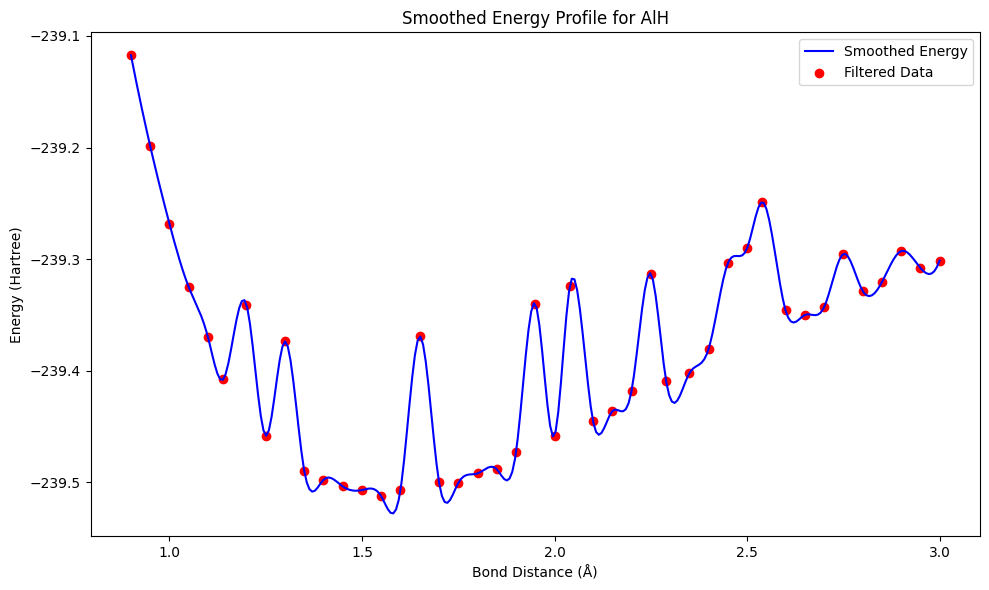

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Input data
data = {
    "AlH_80": -238.883225895786,
    "AlH_85": -238.9508272434401,
    "AlH_90": -239.11725754143856,
    "AlH_95": -239.19872943398195,
    "AlH_100": -239.26828892831955,
    "AlH_105": -239.3248851292711,
    "AlH_110": -239.369906300764,
    "AlH_114": -239.40755393090475,
    "AlH_120": -239.34066229991578,
    "AlH_125": -239.45809279633318,
    "AlH_130": -239.37369286764002,
    "AlH_135": -239.48958799103067,
    "AlH_140": -239.49761072024805,
    "AlH_145": -239.50358387758095,
    "AlH_150": -239.50681615386864,
    "AlH_155": -239.51240062319928,
    "AlH_160": -239.50663936247483,
    "AlH_165": -239.36918759311757,
    "AlH_170": -239.4997685521358,
    "AlH_175": -239.5004753138771,
    "AlH_180": -239.49197213460454,
    "AlH_185": -239.48813806497512,
    "AlH_190": -239.47291312313484,
    "AlH_195": -239.33985722031724,
    "AlH_200": -239.45803444789595,
    "AlH_204": -239.32369586358672,
    "AlH_210": -239.44496924244623,
    "AlH_215": -239.436138278195,
    "AlH_220": -239.4180473162528,
    "AlH_225": -239.31297254223853,
    "AlH_229": -239.40941936606566,
    "AlH_235": -239.402231597707,
    "AlH_240": -239.38063341862022,
    "AlH_245": -239.30378215848788,
    "AlH_250": -239.29034518277462,
    "AlH_254": -239.2487161140633,
    "AlH_260": -239.34587263133324,
    "AlH_265": -239.34993522103835,
    "AlH_270": -239.3431280591017,
    "AlH_275": -239.2953146510574,
    "AlH_280": -239.32825435847187,
    "AlH_285": -239.32071965946295,
    "AlH_290": -239.2927038782272,
    "AlH_295": -239.307725958573,
    "AlH_300": -239.30122089892907
}

# Extract distances and energies
distances = [int(key.split("_")[1]) / 100.0 for key in data.keys()]  # Convert distances to fractional points
energies = list(data.values())

# Remove outliers using z-score
mean_energy = np.mean(energies)
std_energy = np.std(energies)
z_scores = [(energy - mean_energy) / std_energy for energy in energies]
threshold = 2  # Set z-score threshold for outlier detection
filtered_distances = [d for d, z in zip(distances, z_scores) if abs(z) < threshold]
filtered_energies = [e for e, z in zip(energies, z_scores) if abs(z) < threshold]

# Smooth the filtered data
smoothed_distances = np.linspace(min(filtered_distances), max(filtered_distances), 300)
spline = make_interp_spline(filtered_distances, filtered_energies, k=3)
smoothed_energies = spline(smoothed_distances)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(smoothed_distances, smoothed_energies, label="Smoothed Energy", color="blue")
plt.scatter(filtered_distances, filtered_energies, label="Filtered Data", color="red")
plt.xlabel("Bond Distance (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("Smoothed Energy Profile for AlH")
plt.legend()
plt.tight_layout()
plt.savefig("smoothed_energy_profile.png")
plt.show()


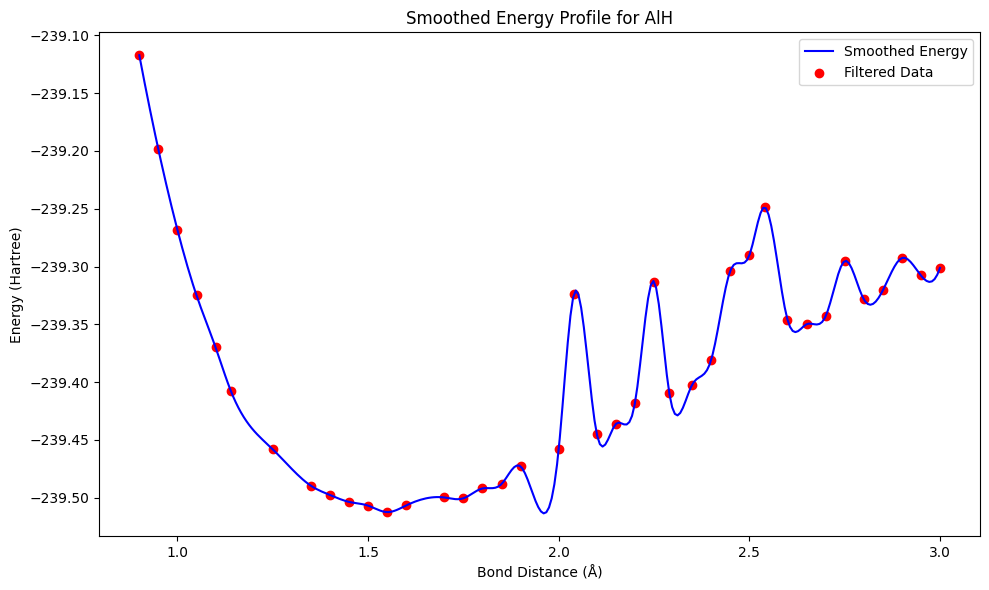

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Input data
data = {
    "AlH_80": -238.883225895786,
    "AlH_85": -238.9508272434401,
    "AlH_90": -239.11725754143856,
    "AlH_95": -239.19872943398195,
    "AlH_100": -239.26828892831955,
    "AlH_105": -239.3248851292711,
    "AlH_110": -239.369906300764,
    "AlH_114": -239.40755393090475,
    "AlH_125": -239.45809279633318,
    "AlH_135": -239.48958799103067,
    "AlH_140": -239.49761072024805,
    "AlH_145": -239.50358387758095,
    "AlH_150": -239.50681615386864,
    "AlH_155": -239.51240062319928,
    "AlH_160": -239.50663936247483,
    "AlH_170": -239.4997685521358,
    "AlH_175": -239.5004753138771,
    "AlH_180": -239.49197213460454,
    "AlH_185": -239.48813806497512,
    "AlH_190": -239.47291312313484,
    "AlH_200": -239.45803444789595,
    "AlH_204": -239.32369586358672,
    "AlH_210": -239.44496924244623,
    "AlH_215": -239.436138278195,
    "AlH_220": -239.4180473162528,
    "AlH_225": -239.31297254223853,
    "AlH_229": -239.40941936606566,
    "AlH_235": -239.402231597707,
    "AlH_240": -239.38063341862022,
    "AlH_245": -239.30378215848788,
    "AlH_250": -239.29034518277462,
    "AlH_254": -239.2487161140633,
    "AlH_260": -239.34587263133324,
    "AlH_265": -239.34993522103835,
    "AlH_270": -239.3431280591017,
    "AlH_275": -239.2953146510574,
    "AlH_280": -239.32825435847187,
    "AlH_285": -239.32071965946295,
    "AlH_290": -239.2927038782272,
    "AlH_295": -239.307725958573,
    "AlH_300": -239.30122089892907
}

# Extract distances and energies
distances = [int(key.split("_")[1]) / 100.0 for key in data.keys()]  # Convert distances to fractional points
energies = list(data.values())

# Remove outliers using z-score
mean_energy = np.mean(energies)
std_energy = np.std(energies)
z_scores = [(energy - mean_energy) / std_energy for energy in energies]
threshold = 2  # Set z-score threshold for outlier detection
filtered_distances = [d for d, z in zip(distances, z_scores) if abs(z) < threshold]
filtered_energies = [e for e, z in zip(energies, z_scores) if abs(z) < threshold]

# Smooth the filtered data
smoothed_distances = np.linspace(min(filtered_distances), max(filtered_distances), 300)
spline = make_interp_spline(filtered_distances, filtered_energies, k=3)
smoothed_energies = spline(smoothed_distances)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(smoothed_distances, smoothed_energies, label="Smoothed Energy", color="blue")
plt.scatter(filtered_distances, filtered_energies, label="Filtered Data", color="red")
plt.xlabel("Bond Distance (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("Smoothed Energy Profile for AlH")
plt.legend()
plt.tight_layout()
plt.savefig("smoothed_energy_profile.png")
plt.show()
